### Libraries

In [1]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

### Networks

In [151]:
import torch.nn as nn

class Psi2QNet(nn.Module):
    def __init__(self, feature_dim):
        super(Psi2QNet, self).__init__()
        self.w = Parameter(torch.Tensor(feature_dim))
        nn.init.constant_(self.w, 0) # CHECK for better initialization
    
    def forward(self, psi):
        return torch.matmul(psi, self.w)

class SRNet_backup(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body, hidden_units=(), gate=F.relu):
        super(SRNet_backup, self).__init__()
        self.body = body
        self.output_dim = output_dim# TODO: check if this is the right way to do it
        dims = (body.feature_dim,) + hidden_units + (body.feature_dim * output_dim,)
        self.layers = nn.ModuleList(
            [layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        
        self.gate = gate
        self.feature_dim = body.feature_dim * output_dim
        self.psi2q = Psi2QNet(body.feature_dim)

    def forward(self, x):
        phi = self.body(tensor(x)) # shape: b x state_dim
        psi = phi
        for layer in self.layers[:-1]:
            psi = self.gate(layer(psi))
        psi = self.layers[-1](psi)
        psi = psi.view(psi.size(0), self.output_dim, self.body.feature_dim) # shape: b x action_dim x state_dim
        out = self.psi2q(psi)

        return phi, psi, out

### DSR base code

In [46]:
#######################################################################
# Copyright (C) 2017 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

"""
DQN code modified to convert it to DSR by Surya.
The representations are not learned in this network.
"""


class DSRActor(BaseActor):
    def __init__(self, config):
        BaseActor.__init__(self, config)
        self.config = config
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        with config.lock:
            _, psi, q_values = self._network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
        next_state, reward, done, info = self._task.step([action])
        
        entry = [self._state[0], action, reward[0], next_state[0], int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class DSRAgent(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []
        self.returns = []

        self.replay = config.replay_fn()
        self.actor = DSRActor(config)

        self.network = config.network_fn()
        self.network.share_memory()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = config.optimizer_fn(self.network.parameters())
        self.w_optimizer = config.optimizer_fn(self.network.psi2q.parameters()) # only on w's

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size)

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, done, info in transitions:

            # Reporting training progress on stdout
            # self.record_online_return(info)
            
            # Recording train returns in list
            for i, info_ in enumerate(info):
                ret = info_['episodic_return']
                if ret is not None:
                    self.returns.append([self.total_steps, ret])
                    
            self.total_steps += 1
            reward = config.reward_normalizer(reward)

            # Putting these new entries in experiences
            experiences.append([state, action, reward, next_state, done])

        # Add experiences to replay
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Sampling from replay buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, terminals = experiences

            # Normalizing stat values
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Computing targets
            _, psi_next, q_next = self.target_network(next_states)
            psi_next = psi_next.detach()
            q_next = q_next.detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                q_next = q_next.max(1) # predicts max q values (vector of b) and corresponding arguments
                a_star = q_next[1]
                q_next = q_next[0]
                psi_next = psi_next[self.batch_indices, a_star, :]

            terminals = tensor(terminals)
            rewards = tensor(rewards)

            # Estimate q target
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)

            # Estimate psi target (obtained from target n/w) # CHECK: should we get target from network instead?
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            psi_next.add_(self.target_network(next_states)[0]) # Adding the prediction for present state.

            # Computing estimates
            actions = tensor(actions).long()
            _, psi, q = self.network(states)
            q = q[self.batch_indices, actions]
            psi = psi[self.batch_indices, actions, :]

            # Estimating the loss
            loss_q = (q_next - q).pow(2).mul(0.5).mean()
            loss_psi = config.c * (psi_next - psi).pow(2).mul(0.5).mean()
            loss = loss_q + loss_psi
            
            # Storing loss estimates
            self.loss_vec.append(loss.item())
            self.loss_q_vec.append(loss_q.item())
            self.loss_psi_vec.append(loss_psi.item())
            
            if(not np.isfinite(loss.item())):
                print(' loss has diverged!')
                import pdb;pdb.set_trace()
                return 
            
            # Update all except w
            self.optimizer.zero_grad()
            loss.backward(retain_graph=True)
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
            with config.lock:
                self.optimizer.step()
                
            # Update w parameters
#             self.w_optimizer.zero_grad()
#             loss_q.backward()
#             nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
#             with config.lock:
#                 self.w_optimizer.step()
                
            

        if self.total_steps / self.config.sgd_update_frequency % \
                self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())

### DSR with seperate loss training

In [40]:
#######################################################################
# Copyright (C) 2017 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

"""
DQN code modified to convert it to DSR by Surya.
The representations are not learned in this network.
"""


class DSRActor(BaseActor):
    def __init__(self, config):
        BaseActor.__init__(self, config)
        self.config = config
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        with config.lock:
            _, psi, q_values = self._network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
        next_state, reward, done, info = self._task.step([action])
        
        entry = [self._state[0], action, reward[0], next_state[0], int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class DSRAgent(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []
        self.returns = []

        self.replay = config.replay_fn()
        self.actor = DSRActor(config)

        self.network = config.network_fn()
        self.network.share_memory()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = config.optimizer_fn(self.network.parameters())
        self.w_optimizer = config.optimizer_fn(self.network.psi2q.parameters()) # only on w's

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size)

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, done, info in transitions:

            # Reporting training progress on stdout
            # self.record_online_return(info)
            
            # Recording train returns in list
            for i, info_ in enumerate(info):
                ret = info_['episodic_return']
                if ret is not None:
                    self.returns.append([self.total_steps, ret])
                    
            self.total_steps += 1
            reward = config.reward_normalizer(reward)

            # Putting these new entries in experiences
            experiences.append([state, action, reward, next_state, done])

        # Add experiences to replay
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Sampling from replay buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, terminals = experiences

            # Normalizing stat values
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Computing targets
            _, psi_next, q_next = self.target_network(next_states)
            psi_next = psi_next.detach()
            q_next = q_next.detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                q_next = q_next.max(1) # predicts max q values (vector of b) and corresponding arguments
                a_star = q_next[1]
                q_next = q_next[0]
                psi_next = psi_next[self.batch_indices, a_star, :]

            terminals = tensor(terminals)
            rewards = tensor(rewards)

            # Estimate q target
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)

            # Estimate psi target (obtained from target n/w) # CHECK: should we get target from network instead?
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            psi_next.add_(self.target_network(next_states)[0]) # Adding the prediction for present state.

            # Computing estimates
            actions = tensor(actions).long()
            _, psi, q = self.network(states)
            q = q[self.batch_indices, actions]
            psi = psi[self.batch_indices, actions, :]

            # Estimating the loss
            loss_q = (q_next - q).pow(2).mul(0.5).mean()
            loss_psi = config.c * (psi_next - psi).pow(2).mul(0.5).mean()
            loss = loss_q + loss_psi
            
            # Storing loss estimates
            self.loss_vec.append(loss.item())
            self.loss_q_vec.append(loss_q.item())
            self.loss_psi_vec.append(loss_psi.item())
            
            if(not np.isfinite(loss.item())):
                print(' loss has diverged!')
                import pdb;pdb.set_trace()
                return 
            
            # Update all except w
            self.optimizer.zero_grad()
            loss_psi.backward(retain_graph=True)
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
            with config.lock:
                self.optimizer.step()
                
            # Update w parameters
            self.w_optimizer.zero_grad()
            loss_q.backward()
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
            with config.lock:
                self.w_optimizer.step()
                
            

        if self.total_steps / self.config.sgd_update_frequency % \
                self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())

In [52]:
def dsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 3

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.00025)
    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
#     config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
#                         Phi2Psi(config.state_dim, config.action_dim, hidden_units=(104,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
#             agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent

In [129]:
### Plotting the results
def convolve(points, kernelSize=5):
    array = np.convolve(points, np.ones(kernelSize), 'valid')
    return array

def plot_dqn(obj, title = 'DQN'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(311)
    plt.plot(convolve(obj.loss_vec, kernelSize=11)/11)
    plt.title(title+' loss ')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(312)
    plt.plot(convolve(obj.loss_vec, kernelSize=111)/111)
    plt.title(title+' smoothed loss ')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(313)
    plt.plot(np.array(obj.returns)[:,0],np.array(obj.returns)[:,1])
    plt.xlabel('timesteps'), plt.ylabel('return')
    plt.title(title+' training performance')
    plt.show()

def plot_dsr(obj, title='DSR'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(211)
    plt.plot(convolve(obj.loss_q_vec, kernelSize=11)/11)
    plt.title(title+' loss')
    plt.ylabel('loss q value'), plt.xlabel('batch no')
    plt.subplot(212)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=11)/11)
    plt.title(title+' loss')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')
    
def plot_dsr2(obj, title='DSR'):
    plt.figure(figsize=(12,4),dpi=100)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=11)/11)
    plt.title(title+' loss')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')

### Rough

In [54]:
a = dsr_feature(game='LineWorld')

Process AsyncReplay-15:
Traceback (most recent call last):
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/mnt/c/Users/Surya Penmetsa/Desktop/McGill Courses/Thesis/code/DeepRL/deep_rl/component/replay.py", line 127, in run
    op, data = self.worker_pipe.recv()
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


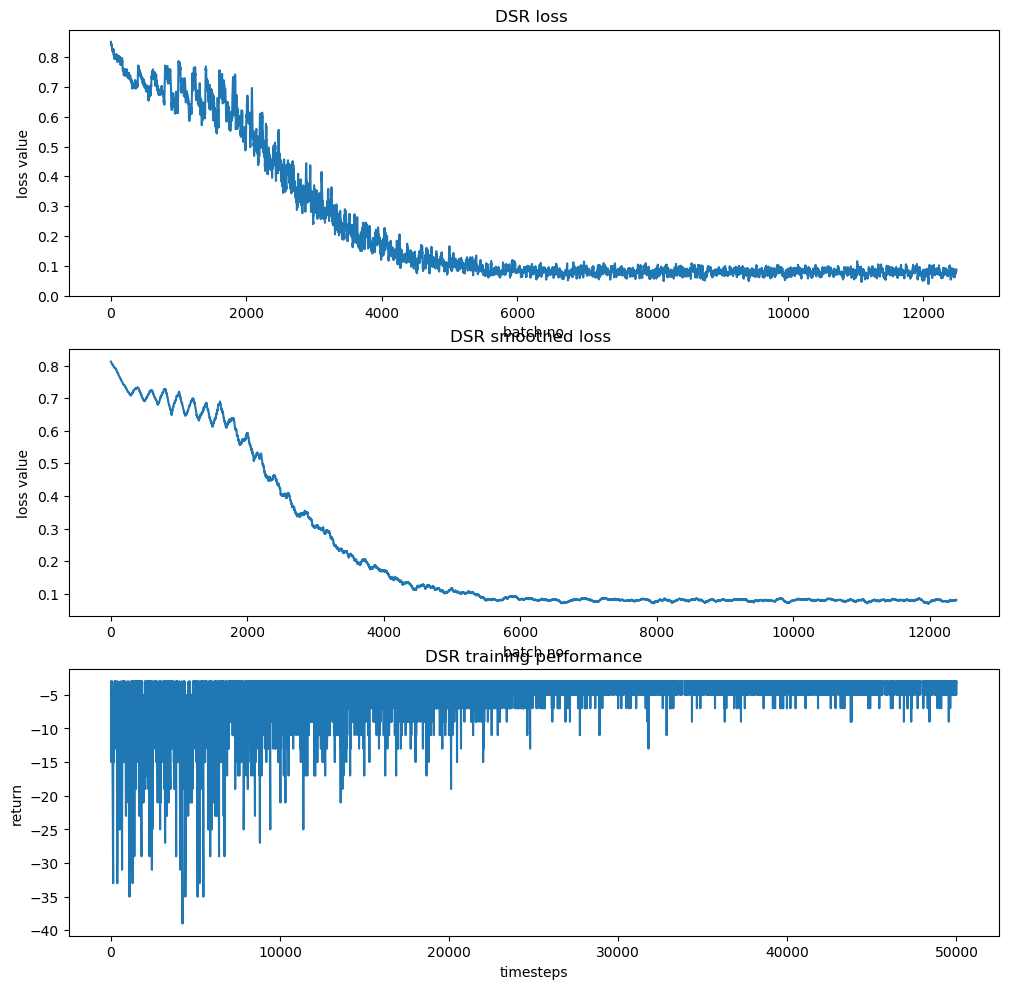

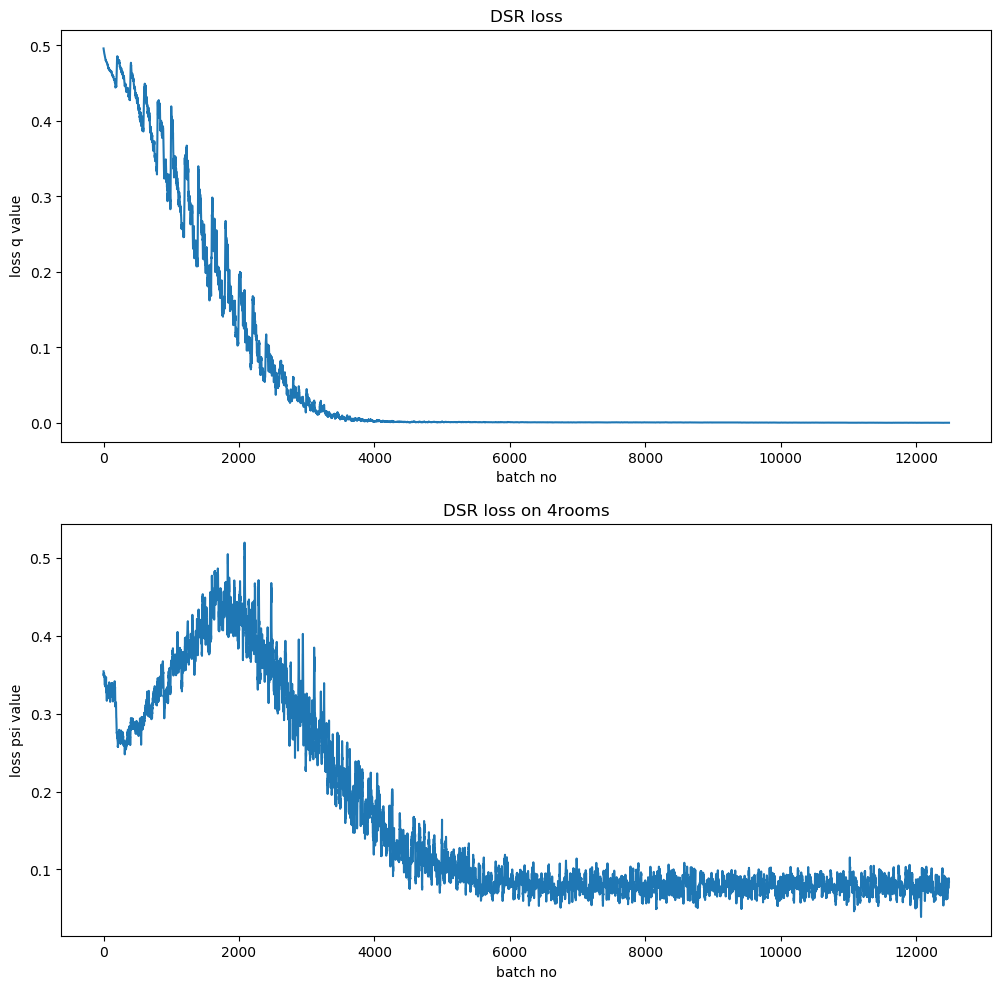

In [55]:
plot_dqn(a, title='DSR')
plot_dsr(a, title='DSR')

2020-04-15 12:01:14,458 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


SRNet_backup(
  (body): SRIdentityBody()
  (layers): ModuleList(
    (0): Linear(in_features=7, out_features=14, bias=True)
  )
  (psi2q): Psi2QNet()
)


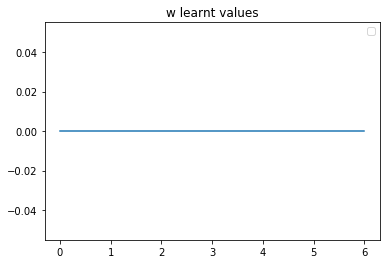

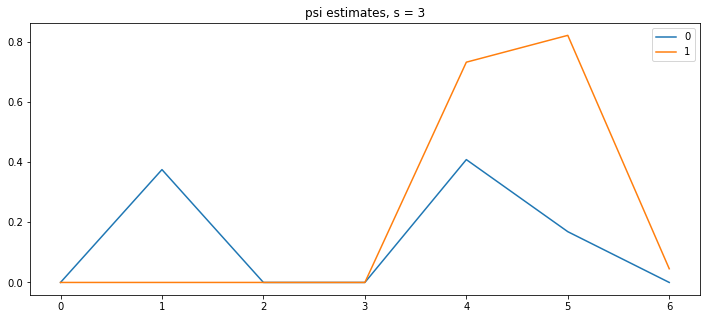

2020-04-15 12:01:14,820 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


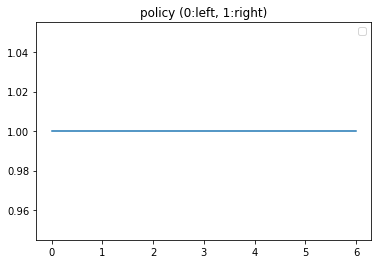

In [146]:
from deep_rl.component.lineworld import LineWorld
env = LineWorld()

def _visualize_vector(vector, title="unnamed", show_goal=False, show=True, label=""):
    plt.plot(vector, label=label)
    plt.title(title)
    if show:
        plt.legend()
        plt.show()
        
def sanity(agent):
    
    print(agent.network)
    
    # Setting things up
    env = LineWorld()
    
    # Visualize w
    w_vector = agent.network.state_dict()['psi2q.w'].numpy()
    _visualize_vector(w_vector, title="w learnt values")
    
    # Visualize psi
    states = [3]
    plt.figure(figsize=(len(states)*12, 5))
    
    for i, s in enumerate(states):
        temp = np.zeros(env.n)
        temp[s] = 1
        phi, psi, q = agent.network(tensor(temp).unsqueeze(0))
        psi = psi.detach().numpy()
        q = q.detach().numpy().flatten()
        _visualize_vector(psi[:,0,:].flatten(), title="q({},{})={}".format(s, 0, q[0]), show=False, label="0")
        _visualize_vector(psi[:,1,:].flatten(), title="psi estimates, s = {}".format(s), show=True, label="1")
            
    # Visualize policy
    state_space = np.identity(env.n)
    phi, psi, q = agent.network(tensor(state_space))
    optimal_actions = q.max(1)[1].detach().numpy()
#     import pdb; pdb.set_trace()
    _visualize_vector(optimal_actions, title='policy (0:left, 1:right)')

    plt.show()
    
sanity(agent_k1)

### Experiments on avSR

In [155]:
import random
"""
Code for learning the averageSR agent across good policies.
"""


class avDSRActor(BaseActor):
    def __init__(self, config, agents):
        BaseActor.__init__(self, config)
        self.config = config
        self.agents = agents
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        

        # Choose one of the base agents randomly
        pick = random.choice(self.agents)

        # Find qvalues of the picked agent for the present state
        with config.lock:
            _, _, q_values = pick.network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()

        # Take action based on this estimated q value
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
            
        next_state, reward, done, info = self._task.step([action])
        
        # Also estimate next action
        #############
        pick2 = random.choice(self.agents)
        with config.lock:
            _, _, q_values = pick2.network(config.state_normalizer(next_state))
        q_values = to_np(q_values).flatten()

        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            next_action = np.random.randint(0, len(q_values))
        else:
            next_action = np.argmax(q_values)
        
        entry = [self._state[0], action, reward[0], next_state[0], next_action, int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class avDSRAgent(BaseAgent):
    def __init__(self, config, agents):
        """
        agents -> list of agents whose actions we need to consider.
        """
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []

        self.replay = config.replay_fn()
        self.actor = avDSRActor(config, agents)

        self.network = config.network_fn()
        self.network.share_memory()
        self.optimizer = config.optimizer_fn(self.network.parameters())

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size) # Need to make this size bigger

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, next_action, done, info in transitions:
#             self.record_online_return(info)
            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, next_action, done])
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Getting samples from buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, next_actions, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Estimate targets
            with torch.no_grad():
                _, psi_next, _ = self.network(next_states)
            psi_next = psi_next.detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                next_actions = tensor(next_actions).long()
                psi_next = psi_next[self.batch_indices, next_actions, :] # TODO: double check dims here

            terminals = tensor(terminals)
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            psi_next.add_(self.network(states)[0]) # TODO: double chec this

#             psi_next = tensor(np.zeros((10, 7)))
#             for i in range(10):
#                 if(torch.all(torch.eq(next_states[i,:], tensor([0., 0., 0., 1., 0., 0., 0.])))):
#                     psi_next[i,:] = tensor([0., 0., 0., 1., 0.99, 0.98, 0.])
#                 elif(torch.all(torch.eq(next_states[i,:], tensor([0., 0., 0., 0., 1., 0., 0.])))):
#                     psi_next[i,:] = tensor([0., 0., 0., 0., 1., 0.99, 0.])
#                 elif(torch.all(torch.eq(next_states[i,:], tensor([0., 0., 0., 0., 0., 1., 0.])))):
#                     psi_next[i,:] = tensor([0., 0., 0., 0., 0., 1., 0.])



#             import pdb; pdb.set_trace()

            # Computing estimates
            actions = tensor(actions).long()
            _, psi, _ = self.network(states)
            psi = psi[self.batch_indices, actions, :]
            
            

            # Estimating the loss
#             import pdb; pdb.set_trace()
#             loss_psi = (psi_next - psi).pow(2).mul(0.5).mean(0)
            loss_psi = (psi_next - psi).pow(2).mul(0.5).mean()

            loss = loss_psi
            
            total_loss = loss.mean()
            self.loss_vec.append(total_loss.item())
            self.loss_psi_vec.append(total_loss.item())
            
            
            self.optimizer.zero_grad()
#             loss.backward(torch.ones(loss.shape))
            loss.backward()

            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)

            with config.lock:
                self.optimizer.step()


In [156]:
def avDSR(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.0002)
#     config.optimizer_fn = lambda params: torch.optim.SGD(params, lr=0.001)

    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e6), batch_size=10)

    config.random_action_prob = LinearSchedule(0.0, 0.0, 1e6) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [157]:
agent_k1 = avDSR(game='LineWorld', agents=[a])
agent_k2 = avDSR(game='LineWorld', agents=[a])

2020-04-15 12:43:32,582 - root - INFO: steps 0, 91180521.74 steps/s
2020-04-15 12:43:33,373 - root - INFO: steps 1000, 1278.58 steps/s
2020-04-15 12:43:34,189 - root - INFO: steps 2000, 1231.39 steps/s
2020-04-15 12:43:34,937 - root - INFO: steps 3000, 1340.92 steps/s
2020-04-15 12:43:35,974 - root - INFO: steps 4000, 967.56 steps/s
2020-04-15 12:43:36,732 - root - INFO: steps 5000, 1326.25 steps/s
2020-04-15 12:43:37,531 - root - INFO: steps 6000, 1257.02 steps/s
2020-04-15 12:43:38,356 - root - INFO: steps 7000, 1215.44 steps/s
2020-04-15 12:43:39,198 - root - INFO: steps 8000, 1192.79 steps/s
2020-04-15 12:43:40,248 - root - INFO: steps 9000, 954.71 steps/s
2020-04-15 12:43:41,225 - root - INFO: steps 10000, 1026.48 steps/s
2020-04-15 12:43:41,992 - root - INFO: steps 11000, 1311.33 steps/s
2020-04-15 12:43:42,746 - root - INFO: steps 12000, 1330.81 steps/s
2020-04-15 12:43:43,529 - root - INFO: steps 13000, 1282.42 steps/s
2020-04-15 12:43:44,518 - root - INFO: steps 14000, 1014.45

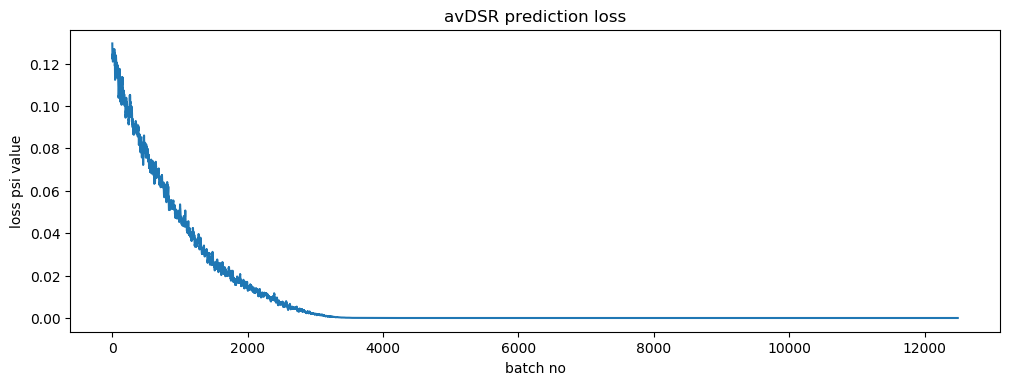

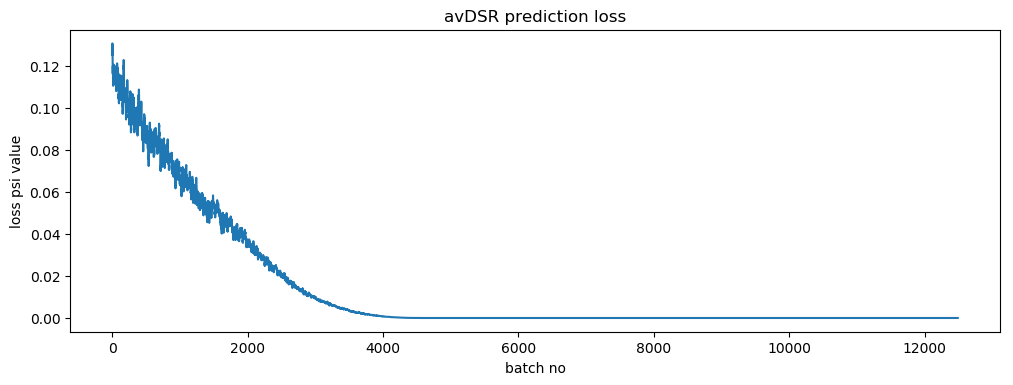

In [158]:
plot_dsr2(agent_k1, 'avDSR prediction')
plot_dsr2(agent_k2, 'avDSR prediction')